In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

# Custom modules
from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from data.mouse import create_mice_dict
from analysis.timepoint_analysis import sample_signals_and_metrics, collect_sessions_data
from analysis.timepoint_analysis import sample_signals_and_metrics, find_drug_split_x

# Config and constants
from config import all_event_types, all_brain_regions
import config

# Plotting libraries
import matplotlib.pyplot as plt

# Signal processing and statistical tools
from scipy.signal import savgol_filter
import scipy.stats as stats
from itertools import product

# Utility libraries
import numpy as np
from tqdm.notebook import tqdm
from ipywidgets import FloatProgress
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
first_mice_sessions = load_and_prepare_sessions("../../../Gq-DREADD_CPT_Training_Stages", load_from_pickle=True, remove_bad_signal_sessions=True,
                                                pickle_name=f'sessions_two_stage1_pre')
first_mice_ids = [s.mouse_id for s in first_mice_sessions]

In [6]:
def update_genotypes(sessions, mice_gen_dict):
    """
    Updates the genotypes for a list of sessions based on the provided genotype mapping.
    Prints whether the genotypes are valid ('TH-Cre', 'Wildtype') 
    and the number of genotype changes made.

    Parameters:
    - sessions: A list of session objects to process.
    - mice_gen_dict: A dictionary mapping mouse IDs to new genotypes.
    """
    geno_mapping = {
        "Cre": "TH-Cre",
        "WT": "Wildtype"
    }
    # Map mice_gen_dict to use TH-Cre and Wildtype
    mapped_genotypes = {k: geno_mapping[v] for k, v in mice_gen_dict.items()}
    
    # Initialize counters and trackers
    valid_genotypes = {'TH-Cre', 'Wildtype'}
    all_genotypes = set()
    genotype_changes = 0

    for session in sessions:
        original_genotype = session.genotype
        int_id = int(session.mouse_id)
        
        if int_id in mapped_genotypes:
            session.genotype = mapped_genotypes[int_id]
            # Count changes if the genotype was updated
            if session.genotype != original_genotype:
                genotype_changes += 1
        
        all_genotypes.add(session.genotype)
    
    # Print results
    if all_genotypes.issubset(valid_genotypes):
        print(f"Valid genotypes found: {all_genotypes}")
    else:
        print(f"Invalid genotypes found: {all_genotypes}")
    
    print(f"Genotype changes made: {genotype_changes}")

In [7]:
mice_gen_dict = {
    69: "Cre",
    71: "WT",
    73: "Cre",
    75: "WT",
    77: "Cre",
    79: "WT",
    85: "WT",
    87: "WT",
    135: "WT",
    137: "WT",
    139: "Cre",
    133: "WT",
    127: "WT",
    125: "WT",
    129: "Cre",
    131: "WT",
    143: "Cre",
    145: "WT",
    147: "WT",
    157: "Cre",
    159: "Cre",
    161: "WT",
    171: "Cre",
    173: "Cre"
}

In [8]:
from collections import defaultdict

# Instead of defaultdict(dict), we need a nested structure keyed by (event, brain_reg, genotype).
# The value remains a dict keyed by (stage, phase).
all_sessions = defaultdict(dict)

stages = ['stage1', 'stage2', 'stage3', 'stage4']
phases = ['pre', 'post']

for stage in stages:
    # Temporary storage for sessions in each phase
    phase_sessions = {}
    
    # Step 1: Load all sessions for the current stage across all phases
    for phase in phases:
        pickle_name = f'sessions_two_{stage}_{phase}'
        
        # Load and prepare sessions
        sessions = load_and_prepare_sessions(
            "../../../Gq-DREADD_CPT_Training_Stages",
            load_from_pickle=True,
            remove_bad_signal_sessions=True,
            pickle_name=pickle_name
        )
        
        # Update genotypes in-place
        update_genotypes(sessions, mice_gen_dict)
        phase_sessions[phase] = sessions
    
    # Step 2: Compute the intersection of mouse IDs across phases
    mouse_ids_pre = set(s.mouse_id for s in phase_sessions['pre'])
    mouse_ids_post = set(s.mouse_id for s in phase_sessions['post'])
    intersection_mouse_ids = mouse_ids_pre.intersection(mouse_ids_post)

    print(f"[INFO] {stage}: {len(intersection_mouse_ids)} common mouse IDs across phases.")
    
    # Step 3: Iterate over each phase and filter sessions by the intersection of mouse IDs
    for phase in phases:
        sessions = phase_sessions[phase]
        filtered_sessions = [s for s in sessions if s.mouse_id in intersection_mouse_ids]
        all_sessions[stage][phase] = filtered_sessions

Valid genotypes found: {'TH-Cre', 'Wildtype'}
Genotype changes made: 1
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 1
[INFO] stage1: 7 common mouse IDs across phases.
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 0
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 2
[INFO] stage2: 13 common mouse IDs across phases.
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 1
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 0
[INFO] stage3: 20 common mouse IDs across phases.
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 0
Valid genotypes found: {'Wildtype', 'TH-Cre'}
Genotype changes made: 0
[INFO] stage4: 6 common mouse IDs across phases.


In [9]:
stages = ['stage1', 'stage2', 'stage3', 'stage4']
phases = ['pre', 'post']

for stage in stages:
    for phase in phases:
        sessions = all_sessions[stage][phase]
        for session in sessions:
            for brain_region in session.brain_regions:
                threshold_x = find_drug_split_x(session, brain_region)
                brain_region = brain_region.split('_')[0]
                for event in config.all_event_types:
                    curr_signal_info = session.signal_info.get((brain_region, event))
                    if curr_signal_info is None:
                        continue
                    signal_idx_ranges = curr_signal_info['signal_idx_ranges']

                    thresholds = np.array([((tup[0] + tup[1]) // 2) for tup in signal_idx_ranges])
                    curr_signal_info["is_above_threshold"] = thresholds > threshold_x

In [10]:
def pair_wise_idxs(raw_df, actions_attr_dict):
    # Define events of interest including 'Display Image'
    events_of_interest = list(actions_attr_dict.keys())

    # Get raw data and filter for events of interest
    item_df = raw_df[["Item_Name"]]
    filtered_df = item_df[item_df["Item_Name"].isin(events_of_interest)].reset_index()

    # Initialize defaultdict to store the pairs
    event_pairs_dict = defaultdict(list)

    # Iterate through the filtered_df row by row
    for i in range(len(filtered_df) - 1):
        current_event = filtered_df.at[i, "Item_Name"]
        next_event = filtered_df.at[i + 1, "Item_Name"]
        if current_event in events_of_interest and next_event in events_of_interest:
            event_pairs_dict[(current_event, next_event)]\
                .append((filtered_df.at[i, "index"], filtered_df.at[i + 1, "index"]))

    return event_pairs_dict

In [11]:
def get_session_pair_signals(session, brain_region, dose, genotype, is_above=True):
    signal_order = []
    all_session_signals = []

    for event in (['hit', 'miss', 'mistake', 'cor_reject']):
        curr_signal_info = session.signal_info.get((brain_region, event))
        if curr_signal_info is None:
            continue
        curr_ranges = curr_signal_info['signal_idx_ranges']

        mask = curr_signal_info["is_above_threshold"]
        if not is_above:
            mask = ~mask

        len_before = sum(len(arr) for arr in all_session_signals)
        all_session_signals.append(curr_signal_info['signal_matrix'][mask])
        len_after = sum(len(arr) for arr in all_session_signals)

        event_list = [event] * len(curr_ranges)
        idx_list = range(len_before, len_after)
        signal_order.extend(zip(curr_ranges, event_list, idx_list))

    if len(signal_order) == 0:
        return None
    _, events, matrix_idx = zip(*sorted(signal_order, key=lambda x: x[0][0]))
    signal_matrix = np.vstack(all_session_signals)[matrix_idx, :]

    pair_dict = defaultdict(list)

    for i in range(len(events) - 1):
        curr_event = events[i]
        next_event = events[i + 1]
        #if next_event == 'hit':
        pair_dict[(curr_event, next_event, brain_region, dose, genotype, is_above)].append(signal_matrix[i+1])

    for k, v in pair_dict.items():
        pair_dict[k] = np.vstack(v)

    return pair_dict

In [12]:
def get_sessions_pair_dict(sessions):
    pair_dict = defaultdict(list)

    for is_above in (True, False):
        for session in sessions:
            for brain_region in config.all_brain_regions:
                for event in (['hit', 'miss', 'mistake', 'cor_reject']):
                    if session.signal_info.get((brain_region, event)) is None:
                            continue

                    genotype = session.genotype
                    dose = (session.drug_info['name'], session.drug_info['dose']) 

                    pair_dict_part = get_session_pair_signals(session, brain_region, genotype, dose, is_above)
                    if pair_dict_part is None:
                        continue
                    for k, v in pair_dict_part.items():
                        pair_dict[k].append(v)

    for k, v in pair_dict.items():
        pair_dict[k] = np.vstack(v)
    
    return pair_dict

In [13]:
brain_reg_to_color = {'LH': 'orange',
                      'mPFC': 'cornflowerblue'}

In [14]:
def preprocess_and_plot_signals(pair_dict, event_type, brain_region, genotype, dose, is_above, stage, phase, smoothing_len=10):
    # Assuming all_signals is predefined
    event1, event2 = event_type
    signals = pair_dict[event1, event2, brain_region, genotype, dose, is_above]

    interval_start = config.peak_interval_config["interval_start"]
    interval_end = config.peak_interval_config["interval_end"]
    fps = config.PLOTTING_CONFIG['cpt']['fps']
    
    xs = np.arange(-interval_start, interval_end) / fps
    
    # Smooth the mean signal
    ys = np.mean(signals, axis=0)
    window = np.ones(smoothing_len) / smoothing_len
    ys = np.convolve(ys, window, 'same')

    # Calculate the standard deviation of the mean
    std_signal = np.std(signals, axis=0) / np.sqrt(len(signals))

    # Use scipy.stats.norm.interval to get the 95% confidence interval
    alpha = 0.95
    ci_lower, ci_upper = stats.norm.interval(alpha, loc=ys, scale=std_signal)

    # The lower and upper bounds
    lb = ci_lower.min()
    ub = ci_upper.max()

    #ylim = (lb, ub)
    if brain_region == 'LH':
        plt.ylim(-.3, 0.5)
    else:
        plt.ylim(-0.25, 0.35)
    
    # Assuming brain_reg_to_color is predefined
    color = brain_reg_to_color[brain_region]

    plt.figure(dpi=300)
    plt.plot(xs[100: -100], ys[100: -100], color=color, label='Mean Signal')
    plt.fill_between(xs[100: -100], ci_lower[100: -100], ci_upper[100: -100], color=color, alpha=0.2, label='95% CI')
    #plt.ylim(ylim)
    plt.title(f'{stage}, {phase}\n {event_type}, {brain_region}, {genotype}, {dose}, is above: {is_above}\n(n = {len(signals)})')
    plt.xlabel('Time (s)')
    plt.ylabel('z-score')
    plt.legend()
    plt.grid()
    plt.savefig(f'{stage}_{phase}_{event1}_to_{event2}_{brain_region}_{genotype}_{dose}_{is_above}.png')
    plt.close()

In [15]:
def plot_all(sessions, stage, phase):
    pair_dict = get_sessions_pair_dict(sessions)

    for k in sorted([k for k in pair_dict.keys() if k is not None], key=lambda x: x[-3]):
        event1, event2, br, genotype, dose, is_above = k
        event = (event1, event2)
        preprocess_and_plot_signals(pair_dict, event, br, genotype, dose, is_above, stage, phase)

/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/fsp585/anaconda3/envs/sund/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


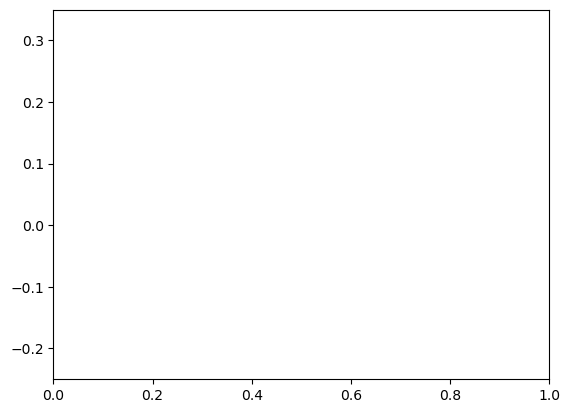

In [16]:
for stage in stages:
    for phase in phases:
        sessions = all_sessions[stage][phase]
        if sessions:
            plot_all(sessions, stage, phase)